In [ ]:
from pymongo import MongoClient
from pprint import pprint
import csv
from collections import defaultdict
from datetime import datetime
import pandas as pd

mongoClient = MongoClient("mongodb://localhost:27017/")
db_polymarket = mongoClient["polygon_polymarket"]
db_orderbook = mongoClient["the-graph-polymarket-orderbook"]


In [ ]:
fpmms = db_polymarket["fpmms"]
fpmmSell = db_polymarket["FPMMSell"]
fpmmBuy = db_polymarket["FPMMBuy"]
fpmmFundingAdded = db_polymarket["FPMMFundingAdded"]
fpmmFundingRemoved = db_polymarket["FPMMFundingRemoved"]

conditions_new = db_orderbook["conditions-new"]
redemptions = db_orderbook["redemptions"]

# without_input_asset_id = fpmmBuy.find({"inputAssetId": {"$exists": False}})
# print(len(list(without_input_asset_id)))

relevant_amms = [
    "0x0464dd2ba3a8100f2ce7c7217559684a63a37699",
    "0x0456cd5c6f4c7d6464605b892fd85c7a09b00cac",
    "0x046aa9b95e5f45da6821dea98e6aa684e6b92c65",
    "0x049cc4d8932fdc33ee568406cdf81d832655340c",
    "0x04a2962b2ada3007a4ae68ac0d853b0056f33179",
    "0x050003ede3e79c10a32c67eb1448762e76309b7d",
    "0x04571ca8baa1f8243907e19367e811c6b593776f",
    "0x0516d8d671cf149de8aa4ee1c4d30da4afb4e0db",
    "0x0544a199e053a143781281b2021c4f01b084584f",
    "0x0565516a3c24e46096d6244644f5bdc4cfa7394d",
    "0x05905ce8782acd74ee4dccba5c2e6c8d52317f2a",
    "0x05b70e0da51fee42bf67d3ac558c327254728f72",
    "0x05f7f7040207ef5c8dc33845d5d7b4fffb720945",
    "0x047704b46c8f5fc899d750341bb7628baaccc1de",
    "0x062eab5656b13b2590eea9183a417eb127f96b6b",
    "0x049e217aff9f06135d7bff8c3fd8be5b7dfd505d",
    "0x06b7a5e0b536ee2c373be3619600d6d8919bd20f",
    "0x06f8e625864c7bec81b2a65f29b8eec20de9ebb9",
    "0x0724bf9b293386d583d0a883aeb41c2d0a652470",
    "0x04e939ec9fc0fdce7fb9f83764ed4b029014a6f9",
    "0x050f902f0a11b77a1b9bb593f1db3ef9f542d280",
    "0x0538a7abefc45420a523d2ff888164816b1e415f",
    "0x055e0d264a2f865c7d5c0a58a2229f66135530fd",
    "0x078cd14be39e09768097388c49687892eb5778fe",
    "0x056c52439d6c59ca0b5f9911975dd1ebc5270374",
    "0x07cd0795c21bea1e7b47895ca3aca9113e792dd0",
    "0x07f076c1ab82ec494d7ca65abdd3435338f6f1ec"
]

amm_based_fpmms = list(fpmms.find({
    "total_interactions": {"$gt": 0},
    "fpmm_address": {"$in": relevant_amms}
}).limit(1000))
print("Number of amm based fpmms: ", len(amm_based_fpmms))
conditions_filtered = list(conditions_new.find({"id": {"$in": [fpmm["conditionId"] for fpmm in amm_based_fpmms]}}))
print("Number of conditions: ", len(list(conditions_filtered)))
redemptions_filtered = list(redemptions.find({"condition.id": {"$in": [fpmm["conditionId"] for fpmm in amm_based_fpmms]}}))
print("Number of redemptions: ", len(list(redemptions_filtered)))

# Group data by ID outside the loop (do this ONCE)
redemptions_by_condition = defaultdict(list)
for redemption in redemptions_filtered:
    redemptions_by_condition[redemption["condition"]["id"]].append(redemption)

conditions_by_id = {}
for condition in conditions_filtered:
    conditions_by_id[condition["id"]] = condition

    
for fpmm in amm_based_fpmms:
    fpmm_address = fpmm["fpmm_address"].lower()
    condition_id = fpmm["conditionId"].lower()
    
    # Fast dictionary lookups instead of list comprehensions
    redemption_details = redemptions_by_condition.get(condition_id, [])
    condition_details = conditions_by_id.get(condition_id, None)

    # Gather all events for this fpmm
    events = []
    lps = set()
    if(condition_details is None or condition_details["resolutionTimestamp"] is None):
        continue
    
    resolution_timestamp = int(condition_details["resolutionTimestamp"])
#     count = 0
#     for e in redemptions_filtered:
#         if(int(e["timestamp"]) < resolution_timestamp):
#             print(e)
#             count += 1
#             # print("fpmm address: ", fpmm_address)
#             # print("condition id: ", condition_id)
#             # print("--------------------------------")
#             # break
# print(count)
    
    # Funding Added
    for e in fpmmFundingAdded.find({"fpmm_address": fpmm_address}):
        lps.add(e["funder"].lower())
        events.append({
            "lp": e["funder"].lower(),
            "type": "FundingAdded",
            "amount": e.get("collateralAmount", None)/10**6,
            "token": "USDC",
            "currency": "USDC",
            "timestamp": datetime.fromtimestamp(e["timestamp"])
        })
    
    # Funding Removed
    for e in fpmmFundingRemoved.find({"fpmm_address": fpmm_address}):
        events.append({
            "lp": e["funder"].lower(),
            "type": "FundingRemoved",
            "amount": e["collateralRemovedFromFeePool"] / 10**6,
            "token": "USDC",
            "currency": "USDC",
            "timestamp": datetime.fromtimestamp(e["timestamp"])
        })
    
    # Sells
    for e in fpmmSell.find({"fpmm_address": fpmm_address}):
        if e["trader"].lower() in lps:
            events.append({
                "lp": e["trader"].lower(),
                "type": "Sell",
                "currency": "USDC" if e.get("outputAssetId", None) == "0x2791bca1f2de4661ed88a30c99a7a9449aa84174" else "BRUH",
                "token": e["inputAssetId"][:4] + "...." + e["inputAssetId"][-4:] if len(e["inputAssetId"]) > 8 else e["inputAssetId"],
                "amount": e.get("outputAmount", None) / 10**6,
                "timestamp": datetime.fromtimestamp(e["timestamp"])
            })
    
    # Buys
    for e in fpmmBuy.find({"fpmm_address": fpmm_address}):
        if e["trader"].lower() in lps:
            events.append({
                "lp": e["trader"].lower(),
                "type": "Buy",
                "currency": "USDC" if e.get("inputAssetId", None) == "0x2791bca1f2de4661ed88a30c99a7a9449aa84174" else "BRUH",
                "token": e["outputAssetId"][:4] + "...." + e["outputAssetId"][-4:] if len(e["outputAssetId"]) > 8 else e["outputAssetId"],
                "amount": e.get("inputAmount", None) / 10**6,
                "timestamp": datetime.fromtimestamp(e["timestamp"])
            })
    
    # Redemptions
    for e in redemptions_filtered:
        if e["redeemer"]["id"].lower() in lps:
            events.append({
                "lp": e["redeemer"]["id"].lower(),
                "type": "Redemption",
                "amount": float(e.get("payout", 0)) / 10**6,
                "token": "USDC",
                "currency": "USDC",
                "timestamp": datetime.fromtimestamp(int(e["timestamp"]))
            })
    
    # Resolution events (not tied to specific LP)
    for e in conditions_new.find({"id": condition_id}):
        events.append({
            "lp": "MARKET",  # Use "MARKET" as a placeholder
            "type": "Resolution",
            "amount": None,
            "token": None,
            "currency": None,
            "timestamp": datetime.fromtimestamp(int(e["resolutionTimestamp"]))
        })

    df = pd.DataFrame(events)
    if not df.empty:
        df = df.sort_values('timestamp')
        
        print(f"\nFPMM: {fpmm_address}")
        
        # Get resolution events to add to each LP timeline
        resolution_events = df[df['type'] == 'Resolution']
        
        # Group by LP and show individual timelines
        for lp in df['lp'].unique():
            if lp == 'MARKET':  # Skip the placeholder resolution LP
                continue
                
            # Get LP's events
            lp_df = df[df['lp'] == lp].copy()
            
            # Add resolution events to this LP's timeline
            for _, res_event in resolution_events.iterrows():
                lp_df = pd.concat([lp_df, pd.DataFrame([{
                    'timestamp': res_event['timestamp'],
                    'lp': lp,
                    'type': '---------RESOLUTIONNNNNNN---------',
                    'amount': "-----------------",
                    'token': "-----------------",
                }])], ignore_index=True)
            
            # Sort by timestamp again
            lp_df = lp_df.sort_values('timestamp')
            
            print(f"\n  LP: {lp}")
            print(lp_df[['timestamp', 'type', 'amount', 'currency', 'token']].to_string(index=False))

    # for sell_event in sell_events:


In [34]:
from pymongo import MongoClient
from collections import defaultdict
from datetime import datetime
import pandas as pd
import re

# Establish database connections
mongoClient = MongoClient("mongodb://localhost:27017/")
db_polymarket = mongoClient["polygon_polymarket"]
db_orderbook = mongoClient["the-graph-polymarket-orderbook"]

# Get collections
fpmms_collection = db_polymarket["fpmms"]
fpmmSell = db_polymarket["FPMMSell"]
fpmmBuy = db_polymarket["FPMMBuy"]
fpmmFundingAdded = db_polymarket["FPMMFundingAdded"]
fpmmFundingRemoved = db_polymarket["FPMMFundingRemoved"]
conditions_new = db_orderbook["conditions-new"]
redemptions = db_orderbook["redemptions"]
splits = db_orderbook["splits"]
merges = db_orderbook["merges"]

# Read the file and extract AMM addresses
relevant_amms = []

try:
    with open('relevant_amms.txt', 'r') as file:
        for line in file:
            # Look for lines containing "Processed" followed by a hex address
            match = re.search(r'Processed\s+(0x[a-fA-F0-9]+)', line.strip())
            if match:
                amm_address = match.group(1).lower()  # Convert to lowercase for consistency
                relevant_amms.append(amm_address)
    
    print(f"Successfully extracted {len(relevant_amms)} AMM addresses from relevant_amms.txt")
    print(f"First few addresses: {relevant_amms[:5]}")
    
except FileNotFoundError:
    print("relevant_amms.txt file not found. Please make sure the file exists in the current directory.")
except Exception as e:
    print(f"Error reading file: {e}")

# --- Data Loading ---
# Using a limit of 100 for demonstration. You can remove this for a full analysis.
amm_based_fpmms = list(fpmms_collection.find({"fpmm_address": {"$in": relevant_amms}}))
print(f"Found {len(amm_based_fpmms)} AMMs to process.")

# Get all FPMM addresses and condition IDs upfront
fpmm_addresses = [fpmm["fpmm_address"].lower() for fpmm in amm_based_fpmms]
fpmm_condition_ids = [fpmm["conditionId"] for fpmm in amm_based_fpmms]

# Query all conditions and redemptions once
conditions_filtered = list(conditions_new.find({"id": {"$in": fpmm_condition_ids}}))
redemptions_filtered = list(redemptions.find({"condition.id": {"$in": fpmm_condition_ids}}))

# Query splits and merges for the relevant conditions
splits_filtered = list(splits.find({"condition.id": {"$in": fpmm_condition_ids}}))
merges_filtered = list(merges.find({"condition.id": {"$in": fpmm_condition_ids}}))

conditions_by_id = {c["id"]: c for c in conditions_filtered}
redemptions_by_condition = defaultdict(list)
for r in redemptions_filtered:
    redemptions_by_condition[r["condition"]["id"]].append(r)

# Group splits and merges by condition ID
splits_by_condition = defaultdict(list)
for s in splits_filtered:
    splits_by_condition[s["condition"]["id"]].append(s)

merges_by_condition = defaultdict(list)
for m in merges_filtered:
    merges_by_condition[m["condition"]["id"]].append(m)

# --- Query all events once and group by FPMM ---
print("Querying all events from database...")

count = 0
# Group funding events by FPMM address
funding_added_by_fpmm = defaultdict(list)
for e in fpmmFundingAdded.find({"fpmm_address": {"$in": fpmm_addresses}}):
    funding_added_by_fpmm[e["fpmm_address"].lower()].append(e)

funding_removed_by_fpmm = defaultdict(list)
for e in fpmmFundingRemoved.find({"fpmm_address": {"$in": fpmm_addresses}}):
    funding_removed_by_fpmm[e["fpmm_address"].lower()].append(e)

# Group trading events by FPMM address
sell_events_by_fpmm = defaultdict(list)
for e in fpmmSell.find({"fpmm_address": {"$in": fpmm_addresses}}):
    sell_events_by_fpmm[e["fpmm_address"].lower()].append(e)
    if (e["fpmm_address"].lower() == "0x6489b85356d911d356aa7e88b4a13c88d0ae0973"):  
        count += 1
print(f"Total funding added events found: {count}")

buy_events_by_fpmm = defaultdict(list)
for e in fpmmBuy.find({"fpmm_address": {"$in": fpmm_addresses}}):
    buy_events_by_fpmm[e["fpmm_address"].lower()].append(e)

print("Database queries completed. Processing events...")

# --- Event Processing ---
all_events = []
for fpmm in amm_based_fpmms:
    fpmm_address = fpmm["fpmm_address"].lower()
    condition_id = fpmm["conditionId"].lower()
    
    condition_details = conditions_by_id.get(condition_id)
    if not condition_details or not condition_details.get("resolutionTimestamp"):
        continue
        
    resolution_timestamp = int(condition_details["resolutionTimestamp"])
    
    # Find all unique LPs for this market from the pre-loaded funding events
    lps = set(e["funder"].lower() for e in funding_added_by_fpmm.get(fpmm_address, []))
    if not lps:
        continue

    # Collect all existing transaction hashes to avoid duplicates
    existing_hashes = set()
    
    # Process funding events for this FPMM using pre-loaded data
    for e in funding_added_by_fpmm.get(fpmm_address, []):
        tx_hash = e.get("transaction_hash", None)
        if tx_hash:
            existing_hashes.add(tx_hash.lower())
        all_events.append({
            "fpmm": fpmm_address, 
            "lp": e["funder"].lower(), 
            "type": "FundingAdded", 
            "amount": e.get("collateralAmount", 0) / 1e6, 
            "timestamp": e["timestamp"], 
            "resolution_timestamp": resolution_timestamp,
            "asset_id": "USDC",
            "quantity": e.get('amountsAdded', []),
            "price": [
                e['amountsAdded'][1] / (e['amountsAdded'][0] + e['amountsAdded'][1]),
                e['amountsAdded'][0] / (e['amountsAdded'][0] + e['amountsAdded'][1])
            ] if e.get('amountsAdded') and len(e['amountsAdded']) >= 2 and (e['amountsAdded'][0] + e['amountsAdded'][1]) > 0 else None,
            "hash": tx_hash,
            "cpmmFee": e.get("CPMMFee", 0) / 1e6
        })
    
    for e in funding_removed_by_fpmm.get(fpmm_address, []):
        tx_hash = e.get("transaction_hash", None)
        if tx_hash:
            existing_hashes.add(tx_hash.lower())
        all_events.append({
            "fpmm": fpmm_address, 
            "lp": e["funder"].lower(), 
            "type": "FundingRemoved", 
            "amount": e.get("collateralRemovedFromFeePool", 0) / 1e6, 
            "timestamp": e["timestamp"], 
            "resolution_timestamp": resolution_timestamp,
            "asset_id": "USDC",
            "quantity": e.get('amountsRemoved', []),
            "price": [
                e['amountsRemoved'][1] / (e['amountsRemoved'][0] + e['amountsRemoved'][1]),
                e['amountsRemoved'][0] / (e['amountsRemoved'][0] + e['amountsRemoved'][1])
            ] if e.get('amountsRemoved') and len(e['amountsRemoved']) >= 2 and (e['amountsRemoved'][0] + e['amountsRemoved'][1]) > 0 else None,
            "hash": tx_hash,
            "cpmmFee": e.get("CPMMFee", 0) / 1e6    
        })
    
    # Only include sell/buy events from LPs (traders who are also LPs)
    for e in sell_events_by_fpmm.get(fpmm_address, []):
        if e["trader"].lower() in lps:
            tx_hash = e.get("transaction_hash", None)
            if tx_hash:
                existing_hashes.add(tx_hash.lower())
            all_events.append({
                "fpmm": fpmm_address, 
                "lp": e["trader"].lower(), 
                "type": "Sell", 
                "amount": e.get("outputAmount", 0) / 1e6, 
                "timestamp": e["timestamp"], 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": e.get("inputAssetId", "USDC"),
                "quantity": [e.get("inputAmount", 0)],
                "price": [(e.get("outputAmount", 0) / e.get("inputAmount", 1))] if e.get("inputAmount") else [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0) / 1e6                
            })
        
    for e in buy_events_by_fpmm.get(fpmm_address, []):
        if e["trader"].lower() in lps:
            tx_hash = e.get("transaction_hash", None)
            if tx_hash:
                existing_hashes.add(tx_hash.lower())
            all_events.append({
                "fpmm": fpmm_address, 
                "lp": e["trader"].lower(), 
                "type": "Buy", 
                "amount": e.get("inputAmount", 0) / 1e6, 
                "timestamp": e["timestamp"], 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": e.get("outputAssetId", "USDC"),
                "quantity": [e.get("outputAmount", 0)],
                "price": [(e.get("inputAmount", 0) / e.get("outputAmount", 1))] if e.get("outputAmount") else [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0) / 1e6                
            })
    
    # Process redemptions for this condition
    for e in redemptions_by_condition.get(condition_id, []):
        if e["redeemer"]["id"].lower() in lps:
            tx_hash = e.get("id", None).lower()  # id is the transaction hash
            if tx_hash:
                existing_hashes.add(tx_hash.lower())
            all_events.append({
                "fpmm": fpmm_address, 
                "lp": e["redeemer"]["id"].lower(), 
                "type": "Redemption", 
                "amount": float(e.get("payout", 0)) / 1e6, 
                "timestamp": int(e["timestamp"]), 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": "USDC",
                "quantity": [],
                "price": [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0) / 1e6
            })
    
    # Process splits for this condition (only if LP and hash not already seen)
    for e in splits_by_condition.get(condition_id, []):
        stakeholder_id = e["stakeholder"]["id"].lower()
        tx_hash = e["id"].lower()  # id is the transaction hash
        
        if stakeholder_id in lps and tx_hash not in existing_hashes:
            all_events.append({
                "fpmm": fpmm_address, 
                "lp": stakeholder_id, 
                "type": "Split", 
                "amount": float(e["amount"]) / 1e6,  # Convert string to float and normalize
                "timestamp": int(e["timestamp"]), 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": "USDC",
                "quantity": [],
                "price": [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0) / 1e6
            })
    
    # Process merges for this condition (only if LP and hash not already seen)
    for e in merges_by_condition.get(condition_id, []):
        stakeholder_id = e["stakeholder"]["id"].lower()
        tx_hash = e["id"].lower()  # id is the transaction hash
        
        if stakeholder_id in lps and tx_hash not in existing_hashes:
            all_events.append({
                "fpmm": fpmm_address, 
                "lp": stakeholder_id, 
                "type": "Merge", 
                "amount": float(e["amount"]) / 1e6,  # Convert string to float and normalize
                "timestamp": int(e["timestamp"]), 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": "USDC",
                "quantity": [],
                "price": [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0) / 1e6
            })

# --- DataFrame Creation ---
df = pd.DataFrame(all_events)
if not df.empty:
    df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s')
    df['resolution_dt'] = pd.to_datetime(df['resolution_timestamp'], unit='s')
    df['relative_time_hours'] = (df['timestamp_dt'] - df['resolution_dt']).dt.total_seconds() / 3600
    print(f"Successfully processed {len(df)} events into a DataFrame.")
    print(f"Event types found: {df['type'].value_counts().to_dict()}")
    print(df.head())
else:
    print("No events found for the selected AMMs.")

Successfully extracted 2643 AMM addresses from relevant_amms.txt
First few addresses: ['0x0464dd2ba3a8100f2ce7c7217559684a63a37699', '0x0456cd5c6f4c7d6464605b892fd85c7a09b00cac', '0x046aa9b95e5f45da6821dea98e6aa684e6b92c65', '0x049cc4d8932fdc33ee568406cdf81d832655340c', '0x04a2962b2ada3007a4ae68ac0d853b0056f33179']
Found 2643 AMMs to process.
Querying all events from database...
Total funding added events found: 778
Database queries completed. Processing events...
Successfully processed 379325 events into a DataFrame.
Event types found: {'Sell': 110858, 'Buy': 91646, 'FundingAdded': 64114, 'FundingRemoved': 58596, 'Merge': 39445, 'Redemption': 12326, 'Split': 2340}
                                         fpmm  \
0  0x049cc4d8932fdc33ee568406cdf81d832655340c   
1  0x049cc4d8932fdc33ee568406cdf81d832655340c   
2  0x049cc4d8932fdc33ee568406cdf81d832655340c   
3  0x049cc4d8932fdc33ee568406cdf81d832655340c   
4  0x049cc4d8932fdc33ee568406cdf81d832655340c   

                               

In [ ]:
import numpy as np

selected_fpmm = "0x6489b85356d911d356aa7e88b4a13c88d0ae0973".lower()
selected_lp = "0x940dfaf6fc332116c0f5484925b1febcebe63bb7".lower()

def format_price_array(x):
    # Handle None/NaN cases first
    if x is None:
        return []
    
    # If it's an array/list, check if it's empty or contains NaN
    if isinstance(x, (list, np.ndarray)):
        if len(x) == 0:
            return ""
        # Check if all elements are NaN
        if all(pd.isnull(val) for val in x):
            return ""
        # Format each non-null price in the array
        formatted_prices = []
        for price in x:
            if pd.notnull(price):
                formatted_prices.append(round(price, 2))
        return formatted_prices
    
    return None
    # Handle scalar values (shouldn't happen based on your description, but just in case)
    # if pd.isnull(x):
    #     return []
    # return f"${x:,.2f}"

def format_quantity(x):
    # Handle None first
    if x is None:
        return None
    
    # Handle arrays/lists
    if isinstance(x, (list, np.ndarray)):
        if len(x) == 0:
            return []
        # Format each valid element
        try:
            formatted = []
            for val in x:
                if pd.notnull(val) and val != "":
                    if isinstance(val, (int, float)):
                        if val >= 1:
                            formatted.append(int(val))  # Return integer for values >= 1
                        else:
                            formatted.append(round(val, 6))  # Return float rounded to 6 decimals
                    else:
                        formatted.append(val)  # Keep original value if not numeric
            return formatted
        except:
            return []
    
    # Handle scalar values
    # if pd.isnull(x) or x == "":
    #     return None
    
    if isinstance(x, (int, float)):
        if x >= 1:
            return int(x)  # Return integer for values >= 1
        else:
            return round(x, 6)  # Return float rounded to 6 decimals
    
    return x  # Return original value if not numeric

# Filter DataFrame for a specific FPMM and LP
filtered_df = df[(df['fpmm'] == selected_fpmm) & (df['lp'] == selected_lp)]

if not filtered_df.empty:
    print(f"\nEvents for FPMM {selected_fpmm} and LP {selected_lp}:")

    # Prepare display DataFrame
    display_df = filtered_df.copy()
    display_df['amount'] = display_df['amount'].apply(lambda x: f"${x:,.2f}" if pd.notnull(x) else "")
    display_df['price'] = display_df['price'].apply(format_price_array)
    display_df['quantity'] = display_df['quantity'].apply(format_quantity)
    
    # Select columns including resolution timestamp
    display_columns = ['timestamp_dt', 'resolution_dt', 'type', 'hash', 'amount', 'asset_id', "price", "quantity"]
    display_df = display_df[display_columns]
    
    # Optionally add a synthetic resolution event row for clarity
    resolution_timestamp = filtered_df['resolution_dt'].iloc[0]  # All events have the same resolution time
    resolution_event = pd.DataFrame([{
        'timestamp_dt': resolution_timestamp,
        'resolution_dt': resolution_timestamp, 
        'type': 'Resolution',
        'hash': '',
        'amount': '',
        'asset_id': '',
        'price': '',
        'quantity': ''
    }])
    
    # Combine and sort
    combined_df = pd.concat([display_df, resolution_event], ignore_index=True)
    combined_df = combined_df.sort_values('timestamp_dt')
    
    print(combined_df.to_string(index=False))
    
    # Calculate and print PnL
    pnl = (
        filtered_df[filtered_df['type'].isin(['FundingRemoved', 'Sell', 'Redemption', 'Merge'])]['amount'].sum()
        - filtered_df[filtered_df['type'].isin(['FundingAdded', 'Buy', 'Split'])]['amount'].sum() - filtered_df['cpmmFee'].sum()
    )
    print(f"\nPnL for LP {selected_lp} in FPMM {selected_fpmm}: ${pnl:,.2f}")

else:
    print("No events found for the selected FPMM and LP.")


Events for FPMM 0x6489b85356d911d356aa7e88b4a13c88d0ae0973 and LP 0x940dfaf6fc332116c0f5484925b1febcebe63bb7:
       timestamp_dt       resolution_dt           type                                                               hash     amount                                                                      asset_id        price                  quantity
2022-06-03 21:07:40 2022-09-05 18:30:54   FundingAdded 0x5f98c7ef7e5174f9264e426e3053e0a9613a8d0af1194ffdedd87db360399d5c $15,000.00                                                                          USDC [0.34, 0.66] [15000000000, 7576854481]
2022-06-03 22:41:59 2022-09-05 18:30:54            Buy 0x7297df770817e8ef743f996f1bb8f051e2384638a426c2a0098150677fa0219e  $1,500.00 50020510440737250328008159708072591412893525445726218563056023860740951051234       [0.67]              [2240382101]
2022-06-04 00:55:43 2022-09-05 18:30:54            Buy 0xf53caf8eb711f0b6d0bab0449bc2b939f6d40c72c496f1e3f73ed3fcbd14a693  $2,000.00 500205

current value if sold: 9635.5355330913 with token holdings: [15000000000, 7576854481] and prices: [0.2773327084619289, 0.7226672915380711]
current value if sold: 9360.238956216857 with token holdings: [14790878707, 7358369427] and prices: [0.2693396609142018, 0.7306603390857982]
current value if sold: 6432.90506236553 with token holdings: [15630082091, 4812260661] and prices: [0.14981245640375945, 0.8501875435962405]


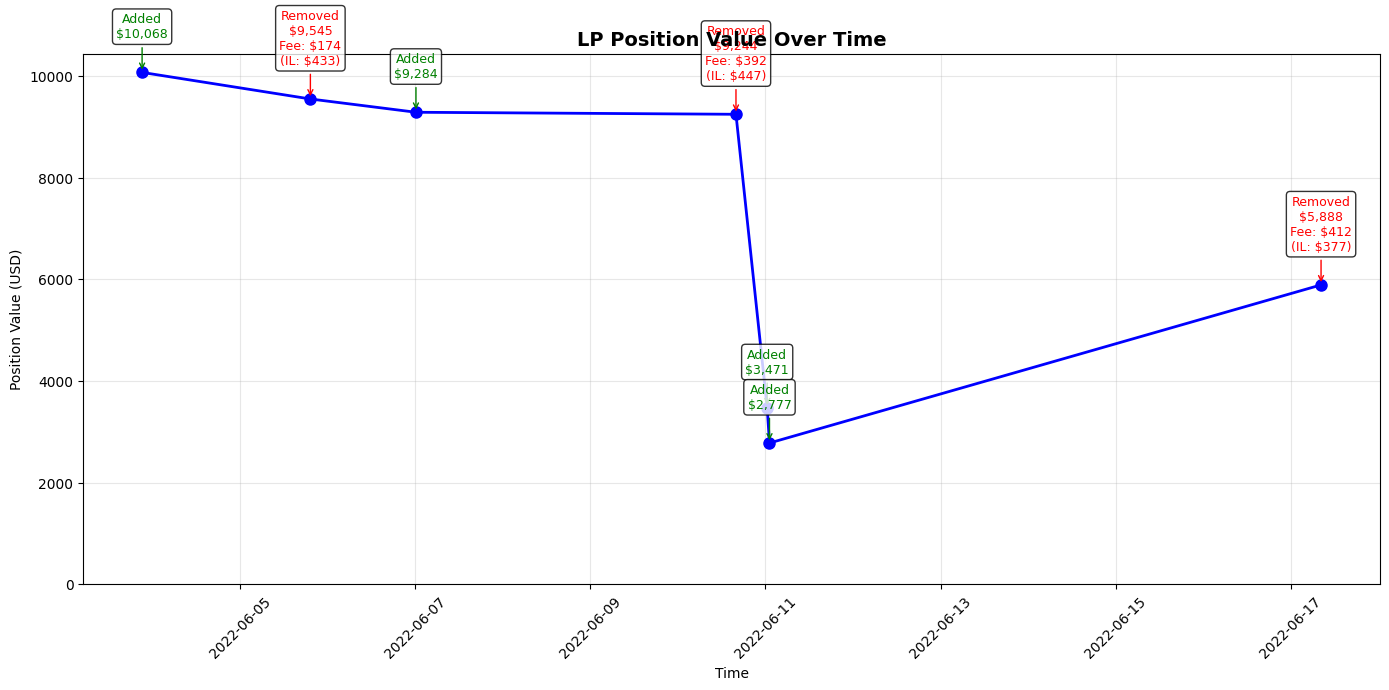

Timeline Details:
2022-06-03 21:07 - Added $15,000 | Position: $10,068
2022-06-05 19:15 - Removed $9,545 + Fee $174 | IL: $433 | Position: $9,545
2022-06-07 00:12 - Added $17,000 | Position: $9,284
2022-06-10 15:55 - Removed $9,244 + Fee $392 | IL: $447 | Position: $9,244
2022-06-11 00:29 - Added $10,000 | Position: $3,471
2022-06-11 01:06 - Added $8,000 | Position: $2,777
2022-06-17 08:19 - Removed $5,888 + Fee $412 | IL: $377 | Position: $5,888


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def simple_lp_timeline(filtered_df):
    timeline = []
    
    # Process funding events only
    funding_events = filtered_df[filtered_df['type'].isin(['FundingAdded', 'FundingRemoved'])].sort_values('timestamp_dt')
    
    lp_token_holdings = [0, 0]  # Track actual token amounts held by LP
    total_locked = 0.0  # Track total amount invested
    
    for _, event in funding_events.iterrows():
        # Get token prices from price column
        # position_value = 0.0  # Start from 0
        if event['price'] and len(event['price']) >= 2:
            prices = event['price']
        else:
            raise Exception("Price data is not available or incomplete for event: ", event)    
        
        if event['type'] == 'FundingAdded':
            amount = event['amount']
            
            # Add tokens from this transaction
            tokens_added = [0, 0]
            for i in range(len(lp_token_holdings)):
                tokens_added[i] = event['quantity'][i] 
                lp_token_holdings[i] += tokens_added[i]
            
            # Calculate position value added in this transaction
            position_added = sum(tokens_added[i] * prices[i] for i in range(len(tokens_added))) / 1e6
            # position_value = position_added
            total_locked += position_added  # Use the actual amount invested
            
            timeline.append({
                'timestamp': event['timestamp_dt'],
                'position_value': total_locked,
                'event_type': 'Added',
                'amount': amount,  # Show the actual amount invested
                'position_added': position_added,  # Track position added for label
                'fee_earned': 0,
                'impermanent_loss': 0,
                'lp_holdings': lp_token_holdings.copy()
            })
            
        elif event['type'] == 'FundingRemoved':
            fee_earned = event['amount']  # This is the fee earned
            
            # Calculate impermanent loss BEFORE removal
            # What would LP get if they sold all tokens at current prices?
            current_value_if_sold = sum(lp_token_holdings[i] * prices[i] for i in range(len(lp_token_holdings))) / 1e6
            print(f"current value if sold: {current_value_if_sold} with token holdings: {lp_token_holdings} and prices: {prices}")
            impermanent_loss = total_locked - current_value_if_sold
            
            # Calculate value of tokens removed using quantity and prices
            value_removed = 0
            if event['quantity'] and len(event['quantity']) >= 2:
                tokens_removed = event['quantity']
                # Calculate value of tokens removed in this transaction
                value_removed = sum((tokens_removed[i] * prices[i]) / 1e6 for i in range(len(tokens_removed)))
                
                # Update LP holdings by removing tokens
                for i in range(len(lp_token_holdings)):
                    lp_token_holdings[i] -= tokens_removed[i]
                
                # position_value -= value_removed
                total_locked -= value_removed
            
            timeline.append({
                'timestamp': event['timestamp_dt'],
                'position_value': total_locked,
                'event_type': 'Removed',
                'amount': value_removed,  # Show actual value removed in this transaction
                'position_added': 0,
                'fee_earned': fee_earned,
                'impermanent_loss': impermanent_loss,
                'lp_holdings': lp_token_holdings.copy()
            })
    
    return pd.DataFrame(timeline)

# Create timeline
timeline_df = simple_lp_timeline(filtered_df)

# # Add origin point
# origin_point = pd.DataFrame([{
#     'timestamp': timeline_df['timestamp'].iloc[0] - pd.Timedelta(hours=1),
#     'position_value': 0,
#     'event_type': 'Origin',
#     'amount': 0,
#     'position_added': 0,
#     'fee_earned': 0,
#     'impermanent_loss': 0,
#     'lp_holdings': [0, 0]
# }])

timeline_df = pd.concat([timeline_df], ignore_index=True)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(timeline_df['timestamp'], timeline_df['position_value'], 
         marker='o', linewidth=2, markersize=8, color='blue')

# Add labels for each event (skip origin)
for _, row in timeline_df[timeline_df['event_type'] != 'Origin'].iterrows():
    if row['event_type'] == 'Added':
        label = f"Added\n${row['position_added']:,.0f}"  # Show actual amount invested
        color = 'green'
    else:  # Removed
        label = f"Removed\n${row['amount']:,.0f}"  # Show actual value removed in this txn
        if row['fee_earned'] > 0:
            label += f"\nFee: ${row['fee_earned']:,.0f}"
        if row['impermanent_loss'] != 0:
            label += f"\n(IL: ${row['impermanent_loss']:,.0f})"
        color = 'red'
    
    plt.annotate(label, 
                xy=(row['timestamp'], row['position_value']),
                xytext=(0, 25), textcoords='offset points',
                ha='center', fontsize=9, color=color,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color=color))

plt.title('LP Position Value Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Position Value (USD)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

# Print timeline
print("Timeline Details:")
for _, row in timeline_df[timeline_df['event_type'] != 'Origin'].iterrows():
    if row['event_type'] == 'Added':
        print(f"{row['timestamp'].strftime('%Y-%m-%d %H:%M')} - Added ${row['amount']:,.0f} | Position: ${row['position_value']:,.0f}")
    else:
        print(f"{row['timestamp'].strftime('%Y-%m-%d %H:%M')} - Removed ${row['amount']:,.0f} + Fee ${row['fee_earned']:,.0f} | IL: ${row['impermanent_loss']:,.0f} | Position: ${row['position_value']:,.0f}")

In [36]:
# Timeline for all FPMMs that a selected LP was involved in
selected_lp = "0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19".lower()

# Get all unique FPMMs this LP is involved in
fpmm_list = df[df['lp'] == selected_lp]['fpmm'].unique()
print(f"FPMMs that LP {selected_lp} was involved in: {len(fpmm_list)} unique FPMMs")

if fpmm_list.size == 0:
    print(f"No events found for LP {selected_lp}.")
else:
    total_pnl = 0
    
    for selected_fpmm in fpmm_list:
        filtered_df = df[(df['fpmm'] == selected_fpmm) & (df['lp'] == selected_lp)]
        
        if not filtered_df.empty:
            print(f"\nEvents for FPMM {selected_fpmm} and LP {selected_lp}:")

            # Prepare display DataFrame
            display_df = filtered_df.copy()
            display_df['amount'] = display_df['amount'].apply(lambda x: f"${x:,.2f}" if pd.notnull(x) else "")
            display_df['price'] = display_df['price'].apply(format_price_array)
            display_df['quantity'] = display_df['quantity'].apply(format_quantity)
            
            # Select columns including resolution timestamp
            display_columns = ['timestamp_dt', 'resolution_dt', 'type', 'hash', 'amount', 'asset_id', "price", "quantity"]
            display_df = display_df[display_columns]
            
            # Optionally add a synthetic resolution event row for clarity
            resolution_timestamp = filtered_df['resolution_dt'].iloc[0]
            resolution_event = pd.DataFrame([{
                'timestamp_dt': resolution_timestamp,
                'resolution_dt': resolution_timestamp, 
                'type': 'Resolution',
                'hash': '',
                'amount': '',
                'asset_id': '',
                'price': '',
                'quantity': ''
            }])
            
            # Combine and sort
            combined_df = pd.concat([display_df, resolution_event], ignore_index=True)
            combined_df = combined_df.sort_values('timestamp_dt')
            
            print(combined_df.to_string(index=False))
            
            # Calculate and print PnL for this FPMM
            pnl = (
                filtered_df[filtered_df['type'].isin(['FundingRemoved', 'Sell', 'Redemption', 'Merge'])]['amount'].sum()
                - filtered_df[filtered_df['type'].isin(['FundingAdded', 'Buy', 'Split'])]['amount'].sum() 
                - filtered_df['cpmmFee'].sum()
            )
            print(f"\nPnL for LP {selected_lp} in FPMM {selected_fpmm}: ${pnl:,.2f}")
            total_pnl += pnl
            
            # total interactions of the selected lp with this fpmm
            # total_interactions = filtered_df.shape[0]
            # print(f"Total interactions of LP {selected_lp} with FPMM {selected_fpmm}: {total_interactions}")
    
    print(f"\n" + "="*50)
    print(f"TOTAL PnL for LP {selected_lp} across all FPMMs: ${total_pnl:,.2f}")

FPMMs that LP 0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19 was involved in: 21 unique FPMMs

Events for FPMM 0x1a7054cd7b650a56cfa6974494e0d9014852edc1 and LP 0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19:
       timestamp_dt       resolution_dt           type                                                               hash    amount                                                                      asset_id        price               quantity
2021-02-18 07:36:55 2021-02-22 16:02:08   FundingAdded 0x1664a9697b116e4a3240898ffb13ad15f78953c12daa126615c8dc2afc6843a3 $4,982.50                                                                          USDC [0.01, 0.99] [4982500000, 35451107]
2021-02-18 07:37:23 2021-02-22 16:02:08 FundingRemoved 0x94fe02472611dfc51542132f93cdde3c08c68d15d0f2bdd1df025a68d0e25230     $0.00                                                                          USDC [0.01, 0.99] [4982499978, 35451107]
2021-02-18 07:37:47 2021-02-22 16:02:08           Sell 0x170b

In [29]:
# Timeline for all LPs that were involved in a selected FPMM
selected_fpmm = "0x6489b85356d911d356aa7e88b4a13c88d0ae0973"

# Get all unique LPs involved in this FPMM
lp_list = df[df['fpmm'] == selected_fpmm]['lp'].unique()

print(f"LPs involved in FPMM {selected_fpmm}: {len(lp_list)} unique LPs")

if lp_list.size == 0:
    print(f"No events found for FPMM {selected_fpmm}.")
else:
    for selected_lp in lp_list:
        filtered_df = df[(df['fpmm'] == selected_fpmm) & (df['lp'] == selected_lp)]
        
        if not filtered_df.empty:
            print(f"\nEvents for FPMM {selected_fpmm} and LP {selected_lp}:")

            # Prepare display DataFrame
            display_df = filtered_df.copy()
            display_df['amount'] = display_df['amount'].apply(lambda x: f"${x:,.2f}" if pd.notnull(x) else "")
            display_df['price'] = display_df['price'].apply(format_price_array)
            display_df['quantity'] = display_df['quantity'].apply(format_quantity)
            
            # Select columns including resolution timestamp
            display_columns = ['timestamp_dt', 'resolution_dt', 'type', 'hash', 'amount', 'asset_id', "price", "quantity"]
            display_df = display_df[display_columns]
            
            # Optionally add a synthetic resolution event row for clarity
            resolution_timestamp = filtered_df['resolution_dt'].iloc[0]
            resolution_event = pd.DataFrame([{
                'timestamp_dt': resolution_timestamp,
                'resolution_dt': resolution_timestamp, 
                'type': 'Resolution',
                'hash': '',
                'amount': '',
                'asset_id': '',
                'price': '',
                'quantity': ''
            }])
            
            # Combine and sort
            combined_df = pd.concat([display_df, resolution_event], ignore_index=True)
            combined_df = combined_df.sort_values('timestamp_dt')
            
            print(combined_df.to_string(index=False))
            
            # Calculate and print PnL for this LP
            pnl = (
                filtered_df[filtered_df['type'].isin(['FundingRemoved', 'Sell', 'Redemption', 'Merge'])]['amount'].sum()
                - filtered_df[filtered_df['type'].isin(['FundingAdded', 'Buy', 'Split'])]['amount'].sum() 
                - filtered_df['cpmmFee'].sum()
            )
            print(f"\nPnL for LP {selected_lp} in FPMM {selected_fpmm}: ${pnl:,.2f}")
            
            # total interactions of the selected lp with this fpmm
            total_interactions = filtered_df.shape[0]
            print(f"Total interactions of LP {selected_lp} with FPMM {selected_fpmm}: {total_interactions}")

LPs involved in FPMM 0x6489b85356d911d356aa7e88b4a13c88d0ae0973: 91 unique LPs

Events for FPMM 0x6489b85356d911d356aa7e88b4a13c88d0ae0973 and LP 0x9d84ce0306f8551e02efef1680475fc0f1dc1344:
       timestamp_dt       resolution_dt           type                                                               hash     amount                                                                      asset_id        price                   quantity
2022-04-28 04:14:27 2022-09-05 18:30:54   FundingAdded 0x57c1059ce95f15a32fe2b1fce57de722139eca0826b2ac9474054f5dd84bf9e6  $5,555.00                                                                          USDC [0.31, 0.69]   [5555000000, 2454120526]
2022-04-28 04:15:31 2022-09-05 18:30:54            Buy 0x3d6bd61bac7fac7d8900cbd3986ccd9081591552c86a26c62dda42262f8df411  $1,111.00 50020510440737250328008159708072591412893525445726218563056023860740951051234       [0.72]               [1539899026]
2022-04-28 04:16:03 2022-09-05 18:30:54            Buy 0x

In [ ]:
import plotly.express as px
import numpy as np

if not df.empty:
    # For better visualization, filter to a specific window, e.g., 7 days before and after resolution
    plot_df = df[df['relative_time_hours'].between(-7*24, 7*24)]

    fig = px.scatter(
        plot_df,
        x="relative_time_hours",
        y="amount",
        color="type",
        title="LP Activity Around Market Resolution",
        labels={"relative_time_hours": "Hours Relative to Resolution", "amount": "Transaction Amount (USDC)"},
        hover_data=['fpmm', 'lp'],
        log_y=True,  # Use a log scale to handle a wide range of amounts
        color_discrete_map={
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
    )

    # Add a vertical line to mark the moment of resolution
    fig.add_vline(x=0, line_width=2, line_dash="dash", line_color="black", annotation_text="Resolution")
    fig.show()
    


In [30]:
# Group by FPMM and LP, calculate PnL for each (across all FPMMs)
lp_fpmm_pnl = []
for (fpmm, lp), group in df.groupby(['fpmm', 'lp']):
    incoming = group[group['type'].isin(['FundingRemoved', 'Sell', 'Redemption', 'Merge'])]['amount'].sum()
    outgoing = group[group['type'].isin(['FundingAdded', 'Buy', 'Split', 'cpmmFee'])]['amount'].sum() + group['cpmmFee'].sum()
    pnl = incoming - outgoing
    lp_fpmm_pnl.append({'fpmm': fpmm, 'lp': lp, 'pnl': pnl, 'outgoing': outgoing})

lp_fpmm_pnl_df = pd.DataFrame(lp_fpmm_pnl)

# For each LP, calculate number of FPMMs, number of profitable FPMMs, percentage, total profit, and profit %
lp_stats = []
for lp, group in lp_fpmm_pnl_df.groupby('lp'):
    total_fpmms = group['fpmm'].nunique()
    profitable_fpmms = (group['pnl'] > 0).sum()
    pct_profitable = profitable_fpmms / total_fpmms if total_fpmms > 0 else 0
    total_profit = group['pnl'].sum()
    total_outgoing = group['outgoing'].sum()
    profit_pct = total_profit / total_outgoing if total_outgoing > 0 else 0
    lp_stats.append({
        'lp': lp,
        'total_fpmms': total_fpmms,
        'profitable_fpmms': profitable_fpmms,
        'pct_profitable': pct_profitable,
        'total_profit': total_profit,
        'profit_pct': profit_pct
    })

# Top 10 LPs by profitable FPMM percentage (with at least 10 FPMMs for significance)
top_10_profitable = sorted([x for x in lp_stats if x['total_fpmms'] >= 10], key=lambda x: x['pct_profitable'], reverse=True)[:20]

print("\nTop 20 LPs by % of Profitable FPMMs (min 10 FPMMs):")
print(f"{'Rank':<4} {'LP Address':<42} {'Profitable':<15} {'Total Profit($)':<18} {'Profit %':<10} {'FPMMs':<6}")
for i, r in enumerate(top_10_profitable, 1):
    print(f"{i:<4} {r['lp']:<42} {r['profitable_fpmms']}/{r['total_fpmms']:<13} ${r['total_profit']:>14,.2f}   {r['profit_pct']*100:>7.2f}%   {r['total_fpmms']:<6}")


Top 20 LPs by % of Profitable FPMMs (min 10 FPMMs):
Rank LP Address                                 Profitable      Total Profit($)    Profit %   FPMMs 
1    0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19 21/21            $      2,335.34      1.48%   21    
2    0x76abc4deb4376bdd94f130316efe8e7483ed60f6 15/16            $      2,479.48      2.09%   16    
3    0x566dc5604f41a1f4f49bacdfd6b03412b3e3f0c9 11/12            $      1,507.70      1.99%   12    
4    0x29f638b0d084a7a54200dcb0ee5ffdcd12b9906b 87/98            $     13,739.88      0.47%   98    
5    0x88186ddbea78ab3d65b7d08f0658b9c22037f265 19/22            $      1,977.34      0.84%   22    
6    0x0c37d01820dae8e51be92f1b82f5eef5f544b228 69/81            $         57.31      0.05%   81    
7    0x0211d17733851605309e400aa4c62991d41cd013 10/12            $     -6,841.09    -17.79%   12    
8    0xe2971abfbecad7a6155f19fe57bd7d0d4b04a1b1 15/18            $    -26,470.54     -3.92%   18    
9    0x40bd8cba0b55e4dfdfaa8b708c0baea

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np

# List of target LPs
target_lps = [
    '0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19',
    '0x76abc4deb4376bdd94f130316efe8e7483ed60f6', 
    '0x566dc5604f41a1f4f49bacdfd6b03412b3e3f0c9',
    '0x29f638b0d084a7a54200dcb0ee5ffdcd12b9906b',
    '0x88186ddbea78ab3d65b7d08f0658b9c22037f265',
    '0x0c37d01820dae8e51be92f1b82f5eef5f544b228',
    '0x0211d17733851605309e400aa4c62991d41cd013',
    '0xe2971abfbecad7a6155f19fe57bd7d0d4b04a1b1',
    '0x40bd8cba0b55e4dfdfaa8b708c0baeae06a630c1',
    '0xfc12bd975d6cc359b43d13967ee3c06c2f0223ef'
    "0xae50d6935c736696a99c309a4dcabe1343b20354"
]

def analyze_lp_entry_prices(target_lp):
    """Analyze the market prices when LP adds funding"""
    
    # Filter for FundingAdded events for this LP
    funding_events = df[(df['lp'] == target_lp) & (df['type'] == 'FundingAdded')]
    
    if funding_events.empty:
        return None
    
    entry_prices = []
    
    for _, event in funding_events.iterrows():
        price_array = event['price']
        
        # Check if price is a valid array with 2 elements
        if isinstance(price_array, list) and len(price_array) >= 2:
            # Take the max of the two prices as entry price
            entry_price = max(price_array)
            entry_prices.append({
                'fpmm': event['fpmm'],
                'entry_price': entry_price,
                'price_array': price_array,
                'amount': event['amount'],
                'timestamp': event['timestamp_dt']
            })
    
    return entry_prices

# Analyze all LPs
print("LP Entry Price Analysis")
print("=" * 80)

summary_results = []

for target_lp in target_lps:
    entry_data = analyze_lp_entry_prices(target_lp)
    
    if not entry_data:
        print(f"\nLP {target_lp[:10]}...: No funding events found")
        continue
    
    # Calculate statistics
    entry_prices = [e['entry_price'] for e in entry_data]
    amounts = [e['amount'] for e in entry_data]
    
    avg_entry_price = np.mean(entry_prices)
    median_entry_price = np.median(entry_prices)
    std_entry_price = np.std(entry_prices)
    
    # Weighted average by amount
    total_amount = sum(amounts)
    weighted_avg_price = sum(price * amount for price, amount in zip(entry_prices, amounts)) / total_amount if total_amount > 0 else 0
    
    # Count entries by price ranges
    extreme_entries = len([p for p in entry_prices if p > 0.8 or p < 0.2])  # Very confident entries
    balanced_entries = len([p for p in entry_prices if 0.4 <= p <= 0.6])   # Balanced entries
    
    summary_results.append({
        'LP': target_lp[:10] + '...',
        'Total_Entries': len(entry_data),
        'Avg_Entry_Price': avg_entry_price,
        'Median_Entry_Price': median_entry_price,
        'Weighted_Avg_Price': weighted_avg_price,
        'Price_Std': std_entry_price,
        'Total_Amount': total_amount,
        'Extreme_Entries': extreme_entries,
        'Balanced_Entries': balanced_entries
    })
    
    print(f"\nLP {target_lp[:10]}...")
    print(f"  Total funding events: {len(entry_data)}")
    print(f"  Average entry price: {avg_entry_price:.4f}")
    print(f"  Median entry price: {median_entry_price:.4f}")
    print(f"  Weighted avg price (by amount): {weighted_avg_price:.4f}")
    print(f"  Price standard deviation: {std_entry_price:.4f}")
    print(f"  Total amount funded: ${total_amount:,.2f}")
    print(f"  Extreme confidence entries (>0.8 or <0.2): {extreme_entries}")
    print(f"  Balanced entries (0.4-0.6): {balanced_entries}")

# Summary table
print(f"\n{'='*80}")
print("SUMMARY TABLE")
print(f"{'='*80}")

summary_df = pd.DataFrame(summary_results)
print(summary_df.round(4).to_string(index=False))

# LP Classification based on entry behavior
print(f"\n{'='*80}")
print("LP ENTRY BEHAVIOR CLASSIFICATION")
print(f"{'='*80}")

for _, row in summary_df.iterrows():
    lp_short = row['LP']
    avg_price = row['Avg_Entry_Price']
    price_std = row['Price_Std']
    extreme_pct = (row['Extreme_Entries'] / row['Total_Entries']) * 100
    balanced_pct = (row['Balanced_Entries'] / row['Total_Entries']) * 100
    
    # Classify LP behavior
    if avg_price > 0.7:
        behavior = "High Confidence Bias (enters when market > 70%)"
    elif avg_price < 0.3:
        behavior = "Contrarian Bias (enters when market < 30%)"
    elif 0.45 <= avg_price <= 0.55:
        behavior = "Balanced Entry (enters around 50/50)"
    elif price_std > 0.2:
        behavior = "Opportunistic (varies entry timing significantly)"
    elif extreme_pct > 50:
        behavior = "Extreme Entry (>50% entries at extreme prices)"
    elif balanced_pct > 50:
        behavior = "Conservative Entry (>50% entries at balanced prices)"
    else:
        behavior = "Mixed Strategy"
    
    print(f"{lp_short}: {behavior}")
    print(f"  Avg: {avg_price:.3f}, Std: {price_std:.3f}, Extreme: {extreme_pct:.1f}%, Balanced: {balanced_pct:.1f}%")

LP Entry Price Analysis

LP 0xd8edcc73...
  Total funding events: 22
  Average entry price: 0.9483
  Median entry price: 0.9889
  Weighted avg price (by amount): 0.9284
  Price standard deviation: 0.0998
  Total amount funded: $156,439.21
  Extreme confidence entries (>0.8 or <0.2): 20
  Balanced entries (0.4-0.6): 1

LP 0x76abc4de...
  Total funding events: 23
  Average entry price: 0.8942
  Median entry price: 0.9507
  Weighted avg price (by amount): 0.8176
  Price standard deviation: 0.1252
  Total amount funded: $105,822.64
  Extreme confidence entries (>0.8 or <0.2): 18
  Balanced entries (0.4-0.6): 1

LP 0x566dc560...
  Total funding events: 26
  Average entry price: 0.7983
  Median entry price: 0.8578
  Weighted avg price (by amount): 0.7764
  Price standard deviation: 0.1560
  Total amount funded: $67,287.83
  Extreme confidence entries (>0.8 or <0.2): 16
  Balanced entries (0.4-0.6): 4

LP 0x29f638b0...
  Total funding events: 410
  Average entry price: 0.9235
  Median entry p

In [11]:
import pandas as pd
from datetime import datetime

# List of target LPs
target_lps = [
    '0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19',
    '0x76abc4deb4376bdd94f130316efe8e7483ed60f6', 
    '0x566dc5604f41a1f4f49bacdfd6b03412b3e3f0c9',
    '0x29f638b0d084a7a54200dcb0ee5ffdcd12b9906b',
    '0x88186ddbea78ab3d65b7d08f0658b9c22037f265',
    '0x0c37d01820dae8e51be92f1b82f5eef5f544b228',
    '0x0211d17733851605309e400aa4c62991d41cd013',
    '0xe2971abfbecad7a6155f19fe57bd7d0d4b04a1b1',
    '0x40bd8cba0b55e4dfdfaa8b708c0baeae06a630c1',
    '0xfc12bd975d6cc359b43d13967ee3c06c2f0223ef'
]

def analyze_lp_activity_patterns(target_lp):
    """Analyze activity patterns for a single LP"""
    
    # Get all FPMMs the LP interacted with (no limit)
    lp_fpmms = df[df['lp'] == target_lp]['fpmm'].unique()
    
    # Prepare data for analysis
    plot_data = []
    
    for i, fpmm_addr in enumerate(lp_fpmms):
        # Get FPMM creation info
        fpmm_doc = fpmms_collection.find_one({"fpmm_address": fpmm_addr})
        
        if fpmm_doc:
            creation_timestamp = fpmm_doc['creation_timestamp']
            creation_date = datetime.fromtimestamp(creation_timestamp)
        else:
            # Fallback if no creation info
            creation_date = df[df['fpmm'] == fpmm_addr]['timestamp_dt'].min() - timedelta(hours=1)
        
        # Filter DataFrame for this FPMM and LP, excluding redemptions
        filtered_df = df[(df['fpmm'] == fpmm_addr) & (df['lp'] == target_lp) & (df['type'] != 'Redemption')]
        
        if not filtered_df.empty:
            resolution_date = filtered_df.iloc[0]['resolution_dt']
            
            # Calculate market duration
            market_duration = (resolution_date - creation_date).total_seconds()
            
            for _, row in filtered_df.iterrows():
                # Calculate relative time as percentage of market lifetime
                time_since_creation = (row['timestamp_dt'] - creation_date).total_seconds()
                relative_time_pct = (time_since_creation / market_duration) * 100 if market_duration > 0 else 0
                
                plot_data.append({
                    'fpmm': fpmm_addr,
                    'fpmm_index': i,
                    'creation_date': creation_date,
                    'resolution_date': resolution_date,
                    'activity_date': row['timestamp_dt'],
                    'relative_time_pct': relative_time_pct,
                    'type': row['type'],
                    'amount': row['amount'] if pd.notnull(row['amount']) else 0,
                    'market_duration_days': market_duration / (24 * 3600)
                })
    
    if not plot_data:
        return None
        
    plot_df = pd.DataFrame(plot_data)
    
    # Activity distribution by market phase
    phase_bins = [0, 25, 50, 75, 100]
    phase_labels = ['Early (0-25%)', 'Mid-Early (25-50%)', 'Mid-Late (50-75%)', 'Late (75-100%)']
    plot_df['phase'] = pd.cut(plot_df['relative_time_pct'], bins=phase_bins, labels=phase_labels, include_lowest=True)
    
    return plot_df

# Analyze all LPs
all_lp_results = {}

for target_lp in target_lps:
    print(f"\n{'='*80}")
    print(f"LP Activity Analysis for {target_lp}")
    print(f"{'='*80}")
    
    result_df = analyze_lp_activity_patterns(target_lp)
    
    if result_df is None or result_df.empty:
        print("No activity data found for this LP")
        continue
    
    all_lp_results[target_lp] = result_df
    
    # Get all FPMMs count
    total_fpmms = len(result_df['fpmm'].unique())
    total_activities = len(result_df)
    
    print(f"Total FPMMs: {total_fpmms}")
    print(f"Total activities (excluding redemptions): {total_activities}")
    
    # Activity distribution by market phase
    print(f"\n--- Activity Distribution by Market Phase ---")
    phase_summary = result_df.groupby(['phase', 'type']).size().unstack(fill_value=0)
    print(phase_summary)
    
    # Phase percentages
    print(f"\n--- Activity by Phase (Percentages) ---")
    phase_pct = result_df['phase'].value_counts(normalize=True).sort_index() * 100
    for phase, pct in phase_pct.items():
        print(f"{phase}: {pct:.1f}%")
    
    # Activity type summary
    print(f"\n--- Activity Type Summary ---")
    type_summary = result_df['type'].value_counts()
    print(type_summary)
    
    # Market duration summary
    print(f"\n--- Market Duration Summary ---")
    duration_summary = result_df.groupby('fpmm')['market_duration_days'].first()
    print(f"Average market duration: {duration_summary.mean():.1f} days")
    print(f"Shortest market: {duration_summary.min():.1f} days")
    print(f"Longest market: {duration_summary.max():.1f} days")
    
    # Timing patterns
    print(f"\n--- Timing Patterns ---")
    avg_timing_by_type = result_df.groupby('type')['relative_time_pct'].agg(['mean', 'median', 'std'])
    print("Average timing by activity type (% of market lifetime):")
    print(avg_timing_by_type.round(1))

# Summary comparison across all LPs
print(f"\n{'='*80}")
print("SUMMARY COMPARISON ACROSS ALL LPs")
print(f"{'='*80}")

summary_data = []
for lp, result_df in all_lp_results.items():
    if result_df is not None and not result_df.empty:
        phase_pct = result_df['phase'].value_counts(normalize=True).sort_index() * 100
        
        summary_data.append({
            'LP': lp[:10] + '...',
            'Total_FPMMs': len(result_df['fpmm'].unique()),
            'Total_Activities': len(result_df),
            'Early_Pct': phase_pct.get('Early (0-25%)', 0),
            'Mid_Early_Pct': phase_pct.get('Mid-Early (25-50%)', 0),
            'Mid_Late_Pct': phase_pct.get('Mid-Late (50-75%)', 0),
            'Late_Pct': phase_pct.get('Late (75-100%)', 0),
            'Avg_Market_Duration': result_df.groupby('fpmm')['market_duration_days'].first().mean(),
            'Most_Common_Activity': result_df['type'].value_counts().index[0],
            'Funding_Activities': len(result_df[result_df['type'].isin(['FundingAdded', 'FundingRemoved'])]),
            'Trading_Activities': len(result_df[result_df['type'].isin(['Buy', 'Sell'])])
        })

summary_df = pd.DataFrame(summary_data)
print("\nLP Behavior Summary:")
print(summary_df.round(1).to_string(index=False))

# Identify LP archetypes
print(f"\n--- LP Archetypes ---")
for _, row in summary_df.iterrows():
    lp_short = row['LP']
    
    # Determine archetype based on activity patterns
    if row['Early_Pct'] > 50:
        archetype = "Early Bird (>50% activity in first 25%)"
    elif row['Late_Pct'] > 50:
        archetype = "Late Trader (>50% activity in last 25%)"
    elif row['Mid_Early_Pct'] + row['Mid_Late_Pct'] > 70:
        archetype = "Mid-Market Trader (active in middle phases)"
    elif row['Funding_Activities'] > row['Trading_Activities'] * 2:
        archetype = "Liquidity Provider (mostly funding activities)"
    elif row['Trading_Activities'] > row['Funding_Activities'] * 2:
        archetype = "Active Trader (mostly buy/sell)"
    else:
        archetype = "Balanced Participant"
    
    print(f"{lp_short}: {archetype}")


LP Activity Analysis for 0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19
Total FPMMs: 21
Total activities (excluding redemptions): 89

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)         0             0               0      0     1      1
Mid-Early (25-50%)    1             3               0      0     5      1
Mid-Late (50-75%)     1             4               2      0     6      0
Late (75-100%)       11            15               1      5    32      0

--- Activity by Phase (Percentages) ---
Early (0-25%): 2.2%
Mid-Early (25-50%): 11.2%
Mid-Late (50-75%): 14.6%
Late (75-100%): 71.9%

--- Activity Type Summary ---
type
Sell              44
FundingAdded      22
Buy               13
Merge              5
FundingRemoved     3
Split              2
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration:

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 16
Total activities (excluding redemptions): 219

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         5             0               0      0     0
Mid-Early (25-50%)    1             6               2      1    17
Mid-Late (50-75%)    10             3               1      3    13
Late (75-100%)       56            14              10     21    56

--- Activity by Phase (Percentages) ---
Early (0-25%): 2.3%
Mid-Early (25-50%): 12.3%
Mid-Late (50-75%): 13.7%
Late (75-100%): 71.7%

--- Activity Type Summary ---
type
Sell              86
Buy               72
Merge             25
FundingAdded      23
FundingRemoved    13
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 64.0 days
Shortest market: 2.3 days
Longest market: 301.6 days

--- Timing Patterns ---
Average timing by activity type (% of mark

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 12
Total activities (excluding redemptions): 419

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)        42             4               0     10     6
Mid-Early (25-50%)   81             5               1      2    39
Mid-Late (50-75%)    42             6               2      6    51
Late (75-100%)       43            11               1     14    53

--- Activity by Phase (Percentages) ---
Early (0-25%): 14.8%
Mid-Early (25-50%): 30.5%
Mid-Late (50-75%): 25.5%
Late (75-100%): 29.1%

--- Activity Type Summary ---
type
Buy               208
Sell              149
Merge              32
FundingAdded       26
FundingRemoved      4
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 25.0 days
Shortest market: 0.8 days
Longest market: 106.0 days

--- Timing Patterns ---
Average timing by activity type (% o

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 98
Total activities (excluding redemptions): 1398

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)         7            19               1      4    22      0
Mid-Early (25-50%)   31            51              14     15    95      0
Mid-Late (50-75%)    30            58              10     25    84      2
Late (75-100%)      116           279              71     65   393      0

--- Activity by Phase (Percentages) ---
Early (0-25%): 3.8%
Mid-Early (25-50%): 14.8%
Mid-Late (50-75%): 15.0%
Late (75-100%): 66.4%

--- Activity Type Summary ---
type
Sell              595
FundingAdded      410
Buy               184
Merge             109
FundingRemoved     98
Split               2
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 13.9 days
Shortest market: 0.7 days
Longest market: 184.1 da

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 22
Total activities (excluding redemptions): 796

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)         0             0               0      0     0      1
Mid-Early (25-50%)   68            14              10      1   126      3
Mid-Late (50-75%)    35            17               8      4    83      4
Late (75-100%)      127            29              10      6   238      9

--- Activity by Phase (Percentages) ---
Early (0-25%): 0.1%
Mid-Early (25-50%): 28.0%
Mid-Late (50-75%): 19.0%
Late (75-100%): 52.8%

--- Activity Type Summary ---
type
Sell              447
Buy               230
FundingAdded       60
FundingRemoved     31
Split              17
Merge              11
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 29.0 days
Shortest market: 0.3 days
Longest market: 223.0 day

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 81
Total activities (excluding redemptions): 694

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         8            15               1      3    23
Mid-Early (25-50%)   12            26               3      8    25
Mid-Late (50-75%)    28            53               9     27    50
Late (75-100%)       43           116              39     49   155

--- Activity by Phase (Percentages) ---
Early (0-25%): 7.2%
Mid-Early (25-50%): 10.7%
Mid-Late (50-75%): 24.1%
Late (75-100%): 58.0%

--- Activity Type Summary ---
type
Sell              254
FundingAdded      210
Buy                91
Merge              87
FundingRemoved     52
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 29.8 days
Shortest market: 1.0 days
Longest market: 178.0 days

--- Timing Patterns ---
Average timing by activity type (% of

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 12
Total activities (excluding redemptions): 79

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         3             4               0      0     3
Mid-Early (25-50%)    2             4               3      3     6
Mid-Late (50-75%)     4             9              13      0    13
Late (75-100%)        1             4               0      0     7

--- Activity by Phase (Percentages) ---
Early (0-25%): 12.7%
Mid-Early (25-50%): 22.8%
Mid-Late (50-75%): 49.4%
Late (75-100%): 15.2%

--- Activity Type Summary ---
type
Sell              29
FundingAdded      21
FundingRemoved    16
Buy               10
Merge              3
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 67.6 days
Shortest market: 7.0 days
Longest market: 184.1 days

--- Timing Patterns ---
Average timing by activity type (% of mark

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 18
Total activities (excluding redemptions): 553

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)        39            16               2     12    18      1
Mid-Early (25-50%)   39            17               5     13    36      0
Mid-Late (50-75%)    23            28              11      8    35      0
Late (75-100%)       60            53              29     29    78      0

--- Activity by Phase (Percentages) ---
Early (0-25%): 15.9%
Mid-Early (25-50%): 19.9%
Mid-Late (50-75%): 19.0%
Late (75-100%): 45.1%

--- Activity Type Summary ---
type
Sell              167
Buy               161
FundingAdded      114
Merge              62
FundingRemoved     48
Split               1
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 51.3 days
Shortest market: 3.9 days
Longest market: 126.5 da

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 11
Total activities (excluding redemptions): 123

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Sell
phase                                                      
Early (0-25%)         6             1               0     5
Mid-Early (25-50%)    9             5               2    26
Mid-Late (50-75%)     4             3               0    12
Late (75-100%)       19             8               2    21

--- Activity by Phase (Percentages) ---
Early (0-25%): 9.8%
Mid-Early (25-50%): 34.1%
Mid-Late (50-75%): 15.4%
Late (75-100%): 40.7%

--- Activity Type Summary ---
type
Sell              64
Buy               38
FundingAdded      17
FundingRemoved     4
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 11.3 days
Shortest market: 0.8 days
Longest market: 29.2 days

--- Timing Patterns ---
Average timing by activity type (% of market lifetime):
                mean  median   std
type           

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 11
Total activities (excluding redemptions): 97

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         5             5               4      4     8
Mid-Early (25-50%)    0             1               1      1     6
Mid-Late (50-75%)     0             2               1      1     5
Late (75-100%)        0             3               0      1     6

--- Activity by Phase (Percentages) ---
Early (0-25%): 48.1%
Mid-Early (25-50%): 16.7%
Mid-Late (50-75%): 16.7%
Late (75-100%): 18.5%

--- Activity Type Summary ---
type
FundingAdded      39
Sell              38
FundingRemoved     8
Merge              7
Buy                5
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 35.4 days
Shortest market: 6.1 days
Longest market: 92.0 days

--- Timing Patterns ---
Average timing by activity type (% of marke

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
import pandas as pd
import plotly.express as px

# Ensure the required DataFrames exist
if 'df' not in locals() or 'pnl_pivot' not in locals():
    print("Please run the Data Preparation (Cell 1) and PnL Calculation (Cell 5) scripts first.")
else:
    # 1. Isolate the last pre-resolution removal for each LP
    pre_resolution_removals = df[(df['type'] == 'FundingRemoved') & (df['relative_time_hours'] < 0)].copy()
    
    if not pre_resolution_removals.empty:
        # Find the timestamp of the last removal for each LP in each market
        last_removal_times = pre_resolution_removals.loc[
            pre_resolution_removals.groupby(['fpmm', 'lp'])['timestamp'].idxmax()
        ]
        
        # Merge this timing information with our main PnL table
        strategy_pnl_df = pd.merge(
            pnl_pivot,
            last_removal_times[['fpmm', 'lp', 'relative_time_hours']],
            on=['fpmm', 'lp'],
            how='left'  # Use a left merge to keep all LPs, even those who didn't remove pre-resolution
        )
        strategy_pnl_df.rename(columns={'relative_time_hours': 'last_removal_hours_before_res'}, inplace=True)

        # 2. Categorize LPs into behavioral groups
        def get_strategy(hours):
            if pd.isna(hours):
                return 'Held Past Resolution'
            elif hours >= -24:
                return 'Removed in Last 24 Hours'
            elif hours >= -168: # 24 * 7
                return 'Removed in Last 1-7 Days'
            else:
                return 'Exited >7 Days Before'

        strategy_pnl_df['strategy'] = strategy_pnl_df['last_removal_hours_before_res'].apply(get_strategy)

        # 3. Calculate PnL statistics for each group
        strategy_summary = strategy_pnl_df.groupby('strategy')['pnl'].agg(
            lp_positions='count',
            mean_pnl='mean',
            median_pnl='median',
            total_pnl='sum'
        ).reset_index()

        print("--- Profitability Analysis by LP Removal Strategy ---")
        print("This table shows the average profit for LPs based on when they removed their liquidity before resolution.")
        print(strategy_summary.to_string(index=False, float_format="$%.2f"))

        # 4. Visualize the distribution of PnL for each strategy
        fig = px.box(
            strategy_pnl_df,
            x='strategy',
            y='pnl',
            color='strategy',
            title='LP Profitability Based on Removal Timing',
            labels={
                'pnl': 'Net PnL (USDC)',
                'strategy': 'LP Strategy'
            },
            category_orders={ # Order the strategies logically
                "strategy": [
                    "Exited >7 Days Before",
                    "Removed in Last 1-7 Days",
                    "Removed in Last 24 Hours",
                    "Held Past Resolution"
                ]
            }
        )
        fig.update_yaxes(range=[strategy_pnl_df['pnl'].quantile(0.05), strategy_pnl_df['pnl'].quantile(0.95)]) # Zoom in on the interquantile range to make the box plots more readable
        fig.add_hline(y=0, line_width=2, line_dash="dash", line_color="black")
        print("\nDisplaying box plot of PnL distribution by strategy...")
        fig.show()

    else:
        print("No pre-resolution funding removal events found to analyze.")


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

if not df.empty:
    # Use the same 7-day window for consistency
    plot_df = df[df['relative_time_hours'].between(-7*24, 7*24)].copy()

    # --- Visualization 1: Faceted Scatter Plot ---
    # This separates each event type into its own subplot to avoid clutter.
    # print("--- Displaying Faceted Scatter Plot ---")
    # fig1 = px.scatter(
    #     plot_df,
    #     x="relative_time_hours",
    #     y="amount",
    #     facet_row="type",  # This is the key change: creates a subplot for each 'type'
    #     title="LP Activity Around Market Resolution (Faceted by Event Type)",
    #     labels={"relative_time_hours": "Hours Relative to Resolution", "amount": "Transaction Amount (USDC)"},
    #     hover_data=['fpmm', 'lp'],
    #     color='type', # Color is still useful for quick identification
    #     color_discrete_map={
    #         'FundingAdded': 'green',
    #         'FundingRemoved': 'red',
    #         'Buy': 'blue',
    #         'Sell': 'orange',
    #         'Redemption': 'purple'
    #     }
    # )
    # # Make the subplots taller and share the x-axis
    # fig1.update_layout(height=1200) 
    # fig1.update_yaxes(matches=None, showticklabels=True) # Give each subplot its own y-axis scale
    # fig1.show()


    # --- Visualization 2: Aggregated Event Volume Plot ---
    # This shows the total volume of activity over time, revealing the flow of capital.
    print("\n--- Displaying Aggregated Event Volume Plot ---")
    
    # Bin the data by hour
    plot_df['time_bin_hours'] = plot_df['relative_time_hours'].round()
    
    # Aggregate volume by type and time bin
    agg_df = plot_df.groupby(['type', 'time_bin_hours'])['amount'].sum().reset_index()

    fig2 = px.line(
        agg_df,
        x='time_bin_hours',
        y='amount',
        color='type',
        title='Aggregated Volume of LP Activity Around Resolution',
        labels={'time_bin_hours': 'Hours Relative to Resolution', 'amount': 'Total Transaction Volume (USDC)'},
        color_discrete_map={
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
    )

    # Add the vertical line for resolution
    fig2.add_vline(x=0, line_width=2, line_dash="dash", line_color="black", annotation_text="Resolution")
    fig2.show()
    
      # --- Visualization 3: Aggregated Event Count Plot ---
    print("\n--- Displaying Aggregated Event Count Plot ---")
    
    # Aggregate event count by type and time bin
    count_df = plot_df.groupby(['type', 'time_bin_hours']).size().reset_index(name='event_count')

    fig3 = px.line(
        count_df,
        x='time_bin_hours',
        y='event_count',
        color='type',
        title='Aggregated Count of LP Activity Events Around Resolution',
        labels={'time_bin_hours': 'Hours Relative to Resolution', 'event_count': 'Number of Events'},
        color_discrete_map={
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
    )

    # Add the vertical line for resolution
    fig3.add_vline(x=0, line_width=2, line_dash="dash", line_color="black", annotation_text="Resolution")
    fig3.show()

else:
    print("DataFrame not available. Please run the data preparation script first.")


volume vs no of trades (more vol and less trades ??)
y-scale profit and x-axis, resolution time
buys after the resolution
sells after the resolution
profit as percentage
volatility (unofficial resolution)

In [ ]:

# 0x6404bfa37fe830e29ee8967e1c3b2a8091d5f250

# --- Pick One Long-term FPMM and Analyze Multiple LPs with PnL ---
if not df.empty:
    # Filter to 2022 events only
    df_2022 = df[df['timestamp_dt'].dt.year == 2022].copy()
    
    print(f"Total events in 2022: {len(df_2022)}")
    
    if df_2022.empty:
        print("No events found in 2022")
    else:
        # --- Find Long-term Markets (>3 months = 90 days) ---
        fpmm_periods = df_2022.groupby('fpmm').agg({
            'timestamp_dt': ['min', 'max'],
            'resolution_dt': 'first',
            'amount': ['count', 'sum'],
            'lp': 'nunique'
        })
        fpmm_periods.columns = ['first_activity', 'last_activity', 'resolution_date', 'tx_count', 'total_volume', 'unique_lps']
        
        # Calculate time to resolution
        fpmm_periods['time_to_resolution_days'] = (fpmm_periods['resolution_date'] - fpmm_periods['first_activity']).dt.days
        
        # Filter to long-term markets (>90 days)
        long_term_markets = fpmm_periods[fpmm_periods['time_to_resolution_days'] > 90].copy()
        long_term_markets = long_term_markets.sort_values('total_volume', ascending=False)
        
        # Pick the top long-term market (most volume)
        selected_fpmm = long_term_markets.index[0]
        market_info = long_term_markets.iloc[0]
        
        print(f"\n--- Selected Long-term Market ---")
        print(f"FPMM: {selected_fpmm}")
        print(f"Resolution period: {market_info['time_to_resolution_days']:.0f} days")
        print(f"Total volume: ${market_info['total_volume']:,.0f}")
        print(f"Total LPs: {market_info['unique_lps']:.0f}")
        
        # Get all events for this FPMM
        fpmm_events = df_2022[df_2022['fpmm'] == selected_fpmm].copy()
        
        # Find top 10 LPs by volume in this market
        lp_activity = fpmm_events.groupby('lp').agg({
            'amount': ['count', 'sum'],
            'timestamp_dt': ['min', 'max'],
            'type': lambda x: list(x.unique())
        })
        lp_activity.columns = ['tx_count', 'total_volume', 'first_date', 'last_date', 'event_types']
        lp_activity = lp_activity.sort_values('total_volume', ascending=False)
        
        # Take top 10 LPs
        top_10_lps = lp_activity.head(10)
        
        print(f"\n--- Top 10 LPs in this Market ---")
        for i, (lp, row) in enumerate(top_10_lps.iterrows(), 1):
            event_types_str = ', '.join(row['event_types'])
            print(f"{i:2d}. {lp[:10]}...{lp[-8:]} | {row['tx_count']:3.0f} txs | ${row['total_volume']:8,.0f} | {event_types_str}")
        
        # Color map for consistency
        color_map = {
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
        
        # --- Calculate PnL for each LP ---
        def calculate_lp_pnl(lp_events):
            # Create pivot table for PnL calculation
            pnl_data = lp_events.groupby('type')['amount'].sum()
            
            # Ensure all event types exist
            for event_type in ['FundingAdded', 'FundingRemoved', 'Buy', 'Sell', 'Redemption']:
                if event_type not in pnl_data:
                    pnl_data[event_type] = 0
            
            # PnL = Cash In - Cash Out
            # Cash In: FundingRemoved, Sell, Redemption
            # Cash Out: FundingAdded, Buy
            cash_in = pnl_data['FundingRemoved'] + pnl_data['Sell'] + pnl_data['Redemption']
            cash_out = pnl_data['FundingAdded'] + pnl_data['Buy']
            pnl = cash_in - cash_out
            
            return pnl, pnl_data
        
        # --- Plot each LP separately ---
        print(f"\n--- Individual LP Strategies in Same Market ---")
        
        lp_summary_data = []
        
        for i, (selected_lp, lp_info) in enumerate(top_10_lps.iterrows(), 1):
            print(f"\n{'-'*50}")
            print(f"LP {i}: {selected_lp}")
            print(f"Activity: {lp_info['tx_count']:.0f} txs, ${lp_info['total_volume']:,.0f}")
            
            # Get this LP's events in the market
            lp_events = fpmm_events[fpmm_events['lp'] == selected_lp].copy()
            lp_events = lp_events.sort_values('timestamp_dt')
            
            if len(lp_events) > 0:
                # Calculate PnL for this LP
                pnl, pnl_breakdown = calculate_lp_pnl(lp_events)
                
                print(f"PnL: ${pnl:,.2f}")
                
                # Create timeline plot for this LP
                fig = px.scatter(
                    lp_events,
                    x="timestamp_dt",
                    y="amount",
                    color="type",
                    title=f"LP {i} Strategy - PnL: ${pnl:,.0f} ({market_info['time_to_resolution_days']:.0f} days)<br>LP: {selected_lp[:10]}... | FPMM: {selected_fpmm[:10]}...",
                    labels={"timestamp_dt": "Date", "amount": "Transaction Amount (USDC)"},
                    color_discrete_map=color_map,
                    hover_data=['relative_time_hours'],
                    log_y=True,
                    height=400
                )
                
                fig.update_layout(
                    xaxis_title="Date (2022)",
                    yaxis_title="Amount (USDC) - Log Scale"
                )
                
                fig.show()
                
                # Event summary for this LP
                event_summary = lp_events.groupby('type')['amount'].agg(['count', 'sum'])
                print("Event breakdown:")
                for event_type, row in event_summary.iterrows():
                    print(f"  {event_type}: {row['count']} txs, ${row['sum']:,.0f}")
                
                print(f"Activity span: {lp_events['timestamp_dt'].min().strftime('%Y-%m-%d')} to {lp_events['timestamp_dt'].max().strftime('%Y-%m-%d')}")
                
                # Calculate strategy metrics
                activity_span_days = (lp_events['timestamp_dt'].max() - lp_events['timestamp_dt'].min()).days
                funding_added = pnl_breakdown['FundingAdded']
                funding_removed = pnl_breakdown['FundingRemoved']
                buy_volume = pnl_breakdown['Buy']
                sell_volume = pnl_breakdown['Sell']
                redemptions = pnl_breakdown['Redemption']
                
                print(f"Strategy metrics:")
                print(f"  Active for: {activity_span_days} days")
                print(f"  Net funding: ${funding_added - funding_removed:,.0f}")
                print(f"  Net trading: ${sell_volume - buy_volume:,.0f}")
                print(f"  Redemptions: ${redemptions:,.0f}")
                print(f"  Total PnL: ${pnl:,.2f}")
                
                # Store data for summary
                lp_summary_data.append({
                    'rank': i,
                    'lp': selected_lp,
                    'activity_days': activity_span_days,
                    'net_funding': funding_added - funding_removed,
                    'net_trading': sell_volume - buy_volume,
                    'redemptions': redemptions,
                    'total_volume': lp_info['total_volume'],
                    'pnl': pnl
                })
        
        print(f"\n{'-'*50}")
        print("Comparison complete!")
        
        # --- Summary Comparison with PnL ---
        print(f"\n--- LP Strategy Comparison Summary ---")
        print("Rank | Activity_Days | Net_Funding | Net_Trading | Redemptions |   PnL    | Total_Volume")
        print("-" * 95)
        
        for data in lp_summary_data:
            print(f"LP_{data['rank']:2d} | {data['activity_days']:11.0f} | ${data['net_funding']:10,.0f} | ${data['net_trading']:10,.0f} | ${data['redemptions']:10,.0f} | ${data['pnl']:7,.0f} | ${data['total_volume']:11,.0f}")
        
        # --- PnL Ranking ---
        lp_summary_df = pd.DataFrame(lp_summary_data)
        lp_summary_df_sorted = lp_summary_df.sort_values('pnl', ascending=False)
        
        print(f"\n--- LP Ranking by PnL ---")
        print("PnL_Rank | Original_Rank | LP_Address | PnL")
        print("-" * 50)
        for pnl_rank, (_, row) in enumerate(lp_summary_df_sorted.iterrows(), 1):
            print(f"{pnl_rank:8d} | {row['rank']:12d} | {row['lp'][:10]}...{row['lp'][-8:]} | ${row['pnl']:8,.0f}")

else:
    print("DataFrame not available.")

In [ ]:
# --- Find Unique Transactions for Specific Market ---
if not df.empty:
    selected_fpmm = "0x6489b85356d911d356aa7e88b4a13c88d0ae0973"
    
    # Filter events for this specific FPMM
    market_events = df[df['fpmm'] == selected_fpmm].copy()
    
    if market_events.empty:
        print(f"No events found for FPMM {selected_fpmm}")
    else:
        print(f"--- Market Analysis for {selected_fpmm[:10]}...{selected_fpmm[-8:]} ---")
        print(f"Total unique transactions: {len(market_events)}")
        
        # Additional breakdown
        print(f"\nBreakdown by event type:")
        event_breakdown = market_events['type'].value_counts()
        for event_type, count in event_breakdown.items():
            print(f"  {event_type}: {count} transactions")
        
        print(f"\nAdditional details:")
        print(f"  Unique LPs involved: {market_events['lp'].nunique()}")
        print(f"  Total volume: ${market_events['amount'].sum():,.2f}")
        print(f"  Activity period: {market_events['timestamp_dt'].min().strftime('%Y-%m-%d')} to {market_events['timestamp_dt'].max().strftime('%Y-%m-%d')}")
        
        # Check if it's from 2022 or other years
        year_breakdown = market_events['timestamp_dt'].dt.year.value_counts().sort_index()
        print(f"\nActivity by year:")
        for year, count in year_breakdown.items():
            print(f"  {year}: {count} transactions")

else:
    print("DataFrame not available.")